In [ ]:
import torch
print(f"PyTorch CUDA available: {torch.cuda.is_available()}")
print(f"PyTorch CUDA version: {torch.version.cuda}")

from torch import nn
import torch.cuda.nvtx as nvtx
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
import os
from torch.utils.cpp_extension import load_inline, load
torch.utils.cpp_extension.CUDA_HOME = '/usr/local/cuda-13.0'
print(f"torch.utils.cpp_extension.CUDA_HOME reports: {torch.utils.cpp_extension.CUDA_HOME}")

device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")
torch.manual_seed(2244)

# Define the CUDA kernel and C++ wrapper
cuda_source = '''
__global__ void square_matrix_kernel(const float* matrix, float* result, int width, int height) {
    int row = blockIdx.y * blockDim.y + threadIdx.y;
    int col = blockIdx.x * blockDim.x + threadIdx.x;

    if (row < height && col < width) {
        int idx = row * width + col;
        result[idx] = matrix[idx] * matrix[idx];
    }
}

torch::Tensor square_matrix(torch::Tensor matrix) {
    const auto height = matrix.size(0);
    const auto width = matrix.size(1);

    auto result = torch::empty_like(matrix);

    dim3 threads_per_block(16, 16);
    dim3 number_of_blocks((width + threads_per_block.x - 1) / threads_per_block.x,
                          (height + threads_per_block.y - 1) / threads_per_block.y);

    square_matrix_kernel<<<number_of_blocks, threads_per_block>>>(
        matrix.data_ptr<float>(), result.data_ptr<float>(), width, height);

    return result;
}
'''

cpp_source = "torch::Tensor square_matrix(torch::Tensor matrix);"

# Load the CUDA kernel as a PyTorch extension
square_matrix_extension = load_inline(
    name='square_matrix_extension',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['square_matrix'],
    with_cuda=True,
    extra_cuda_cflags=["-O3"],
    build_directory='./load_inline_cuda',
    # extra_cuda_cflags=['--expt-relaxed-constexpr']
)

a = torch.tensor([[1., 2., 3.], [4., 5., 6.]], device='cuda')
print(square_matrix_extension.square_matrix(a))

In [ ]:
a = torch.rand(1000, 1000, device='cuda')
b = square_matrix_extension.square_matrix(a)
a, b, b.shape

In [ ]:
cuda_source = '''
#include <curand.h>

#define gpuErrchk(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line, bool abort=true)
{
   if (code != cudaSuccess) 
   {
      fprintf(stderr,"GPUassert: %s %s %d\\n", cudaGetErrorString(code), file, line);
      if (abort) exit(code);
   }
}

constexpr uint64_t multiplier = 6364136223846793005u;
constexpr uint64_t increment  = 1442695040888963407u;	// Or an arbitrary odd constant
constexpr float pcg_norm = 1.f / 4294967296.f;
constexpr int THREADS_PER_BLOCK = 128;

__host__ __device__ uint32_t rotr32(uint32_t x, unsigned r) {
	return x >> r | x << (-r & 31);
}

__host__ __device__ uint32_t pcg32(uint64_t& state) {
	uint64_t x = state;
	unsigned count = (unsigned)(x >> 59);		// 59 = 64 - 5

	state = x * multiplier + increment;
	x ^= x >> 18;								// 18 = (64 - 27)/2
	return rotr32((uint32_t)(x >> 27), count);	// 27 = 32 - 5
}

__host__ __device__ void pcg32_init(uint64_t seed, uint64_t& state) {
	state = seed + increment;
	(void)pcg32(state);
}

__host__ __device__ float randf_pcg32(float min_val, float max_val, uint64_t& state) {
    uint32_t randint = pcg32(state);
    float rand01 = randint * pcg_norm;
    return min_val + rand01 * (max_val - min_val);
}

__global__ void init_pcg_states_kernel(uint64_t* pcg_states, int max_size) {
	int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < max_size) {
        pcg_states[idx] = 0x4d595df4d0f33173;
        pcg32_init(idx, pcg_states[idx]);
    }
}

uint64_t* d_pcg_states;
void pcg_init(int max_size) {
	gpuErrchk(cudaMalloc(&d_pcg_states, max_size * sizeof(uint64_t)));
	int num_blocks = (max_size + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK;
	init_pcg_states_kernel<<<num_blocks, THREADS_PER_BLOCK>>>
 		(d_pcg_states, max_size);
}

void pcg_destroy() {
	gpuErrchk(cudaFree(d_pcg_states));
}


/*
        for id in range(self.NP):
            nvtx.range_push(f"updating model {id}")
            if fy[id] <= fx[id]:
                for i in range(len(self.layers)):
                    self.layers[i][id].copy_(y_layers[i][id])
                    self.biases[i][id].copy_(y_biases[i][id])
                fx[id] = fy[id]
            if fx[id] < self.min_l:
                self.best_model = id
                self.min_l = fx[id]
            nvtx.range_pop() */

// MOVE d_y_params, d_mask INTO SHARED MEMORY, IDX >= NP SO JUST USE THE FIRST NP THREADS TO COOPERATIVELY LOAD
__global__ void update_population_kernel(float* d_params, const float* d_y_params, const uint8_t* d_mask, int NP, int size) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;

    if (idx < NP * size) {
        int id = idx / size;
        
        if (d_mask[id]) {
            d_params[idx] = d_y_params[idx];
        }
    }
}

void de_update_cuda(int NP, std::vector<torch::Tensor>& layers, std::vector<torch::Tensor>& biases, const std::vector<torch::Tensor>& y_layers, const std::vector<torch::Tensor>& y_biases, torch::Tensor& fx, const torch::Tensor& fy, torch::Tensor& min_f, torch::Tensor& best_model) {
    int num_layers = layers.size();
    auto mask = torch::le(fy, fx).to(torch::kUInt8);
    auto d_mask_ptr = mask.data_ptr<uint8_t>();
    
    for (int i = 0; i < num_layers; i++) {
        torch::Tensor& layer = layers[i];
        TORCH_CHECK(layer.is_contiguous(), "'layers[", i, "]' must be contiguous");
		torch::Tensor& bias = biases[i];
        TORCH_CHECK(bias.is_contiguous(), "'biases[", i, "]' must be contiguous");

        torch::Tensor y_layer_contig = y_layers[i].contiguous();
		torch::Tensor y_bias_contig = y_biases[i].contiguous();
        update_population_kernel<<<(layer.numel() + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK, THREADS_PER_BLOCK>>>
        	(layer.data_ptr<float>(), y_layer_contig.data_ptr<float>(), d_mask_ptr, NP, layer.numel() / NP);
        update_population_kernel<<<(bias.numel() + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK, THREADS_PER_BLOCK>>>
        	(bias.data_ptr<float>(), y_bias_contig.data_ptr<float>(), d_mask_ptr, NP, bias.numel() / NP);
    }
    
    fx.copy_(torch::where(mask.to(torch::kBool), fy, fx));
    
    auto min_tuple = torch::min(fx, 0);
    auto new_min_f = std::get<0>(min_tuple);
    auto new_best_model = std::get<1>(min_tuple);
    min_f.copy_(new_min_f);
    best_model.copy_(new_best_model);
    
    cudaDeviceSynchronize();
}


// MOVE best_model (parameters), d_agent0_ids, d_agent1_ids, d_Rs, INTO SHARED MEMORY
__global__ void de_crossover_kernel2(int NP, float CR, float F, int best_model, float* d_ptr, float* d_out_ptr, int size, int layer_idx, int num_layers, int* d_agent0_ids, int* d_agent1_ids, int* d_Rs, uint64_t* pcg_states) {
 	int idx = blockIdx.x * blockDim.x + threadIdx.x;
  	extern __shared__ float shared_buffer[];
	shared_buffer[threadIdx.x] = d_ptr[best_model * size + idx % size];
	
 	__syncthreads();
	float* best_model_params = shared_buffer;

	if (idx < NP * size) {
		int id = idx / size; // candidate id
		float ri = randf_pcg32(0, 1, pcg_states[idx]);
  
		// printf("id %d, agent_ids [%d, %d], R %d, (num_layers %d), ri %.3f\\n", id, agent_ids[0], agent_ids[1], R, num_layers, ri);

		if (ri < CR || layer_idx == d_Rs[id]) {
			d_out_ptr[idx] = d_ptr[idx] + F * (best_model_params[threadIdx.x] - d_ptr[idx]) +
   				F * (d_ptr[d_agent0_ids[id] * size + idx % size] - d_ptr[d_agent1_ids[id] * size + idx % size]);
		}
	}
}

// MOVE pcg_states INTO SHARED MEMORY
__global__ void de_rng_kernel(int NP, int* d_agent0_ids, int* d_agent1_ids, int* d_Rs, int num_layers, uint64_t* pcg_states) {
	int id = blockIdx.x * blockDim.x + threadIdx.x;
 
	if (id < NP) {
		d_Rs[id] = (int)randf_pcg32(0, num_layers, pcg_states[id]);
		
  		do {
			d_agent0_ids[id] = (int)randf_pcg32(0, NP, pcg_states[id]);
		} while (d_agent0_ids[id] == id);

		do {
			d_agent1_ids[id] = (int)randf_pcg32(0, NP, pcg_states[id]);
		} while (d_agent1_ids[id] == id || d_agent1_ids[id] == d_agent0_ids[id]);
	}
}

std::vector<std::vector<torch::Tensor>> de_crossover_cuda2(const std::vector<torch::Tensor>& layers, const std::vector<torch::Tensor>& biases, int64_t NP, double CR, double F, const torch::Tensor& best_model) {
	int num_layers = layers.size();
	std::vector<float*> layer_ptrs(num_layers), bias_ptrs(num_layers);
 	std::vector<float*> out_layer_ptrs(num_layers), out_bias_ptrs(num_layers);
	std::vector<torch::Tensor> out_layers(num_layers), out_biases(num_layers);
 
	int best_model_val = best_model.item<int>();
 	int* d_agent0_ids;
	int* d_agent1_ids;
	int* d_Rs;
	gpuErrchk(cudaMalloc(&d_agent0_ids, NP * sizeof(int)));
 	gpuErrchk(cudaMalloc(&d_agent1_ids, NP * sizeof(int)));
	gpuErrchk(cudaMalloc(&d_Rs, NP * sizeof(int)));
 
	de_rng_kernel<<<(NP + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK, THREADS_PER_BLOCK>>>
 		(NP, d_agent0_ids, d_agent1_ids, d_Rs, num_layers, d_pcg_states);
 	gpuErrchk(cudaDeviceSynchronize());

	for (int i = 0; i < num_layers; i++) {
     	//printf("layer %d:\\n", i);
		torch::Tensor layer_contig = layers[i].contiguous();
		torch::Tensor bias_contig = biases[i].contiguous();
		layer_ptrs[i] = layer_contig.data_ptr<float>();
		bias_ptrs[i] = bias_contig.data_ptr<float>();

		out_layers[i] = torch::clone(layer_contig);
		out_biases[i] = torch::clone(bias_contig);
		out_layer_ptrs[i] = out_layers[i].data_ptr<float>();
		out_bias_ptrs[i] = out_biases[i].data_ptr<float>();
		
		de_crossover_kernel2<<<max(1l, (layer_contig.numel() + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK), THREADS_PER_BLOCK, THREADS_PER_BLOCK * sizeof(float)>>>
  			(NP, CR, F, best_model_val, layer_ptrs[i], out_layer_ptrs[i], layer_contig.numel() / NP, i, num_layers, d_agent0_ids, d_agent1_ids, d_Rs, d_pcg_states);
		de_crossover_kernel2<<<max(1l, (bias_contig.numel() + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK), THREADS_PER_BLOCK, THREADS_PER_BLOCK * sizeof(float)>>>
  			(NP, CR, F, best_model_val, bias_ptrs[i], out_bias_ptrs[i], bias_contig.numel() / NP, i, num_layers, d_agent0_ids, d_agent1_ids, d_Rs, d_pcg_states);
		//gpuErrchk(cudaDeviceSynchronize());
	}
 
   	gpuErrchk(cudaDeviceSynchronize());
    gpuErrchk(cudaFree(d_agent0_ids));
    gpuErrchk(cudaFree(d_agent1_ids));
	gpuErrchk(cudaFree(d_Rs));
 	//std::cout << "crossover finished" << std::endl;
 	return {out_layers, out_biases};
}

__global__ void de_crossover_kernel(int NP, float CR, float F, int best_model, float* d_ptr, float* d_out_ptr, int size, float* d_all_agent_ids, float* d_Rs, float* d_ris, int layer_idx, int num_layers) {
	int idx = blockIdx.x * blockDim.x + threadIdx.x;

	if (idx < NP * size) {
		int id = idx / size; // candidate id
		int agent_ids[3]{d_all_agent_ids[id * 3 + 0] * NP, d_all_agent_ids[id * 3 + 1] * NP, d_all_agent_ids[id * 3 + 2] * NP};
		//printf("id: %d, best model: %d, agent 0: %d, agent 1: %d\\n", id, best_model, agent_ids[0], agent_ids[1]);
		int R = d_Rs[id] * num_layers;
		float ri = d_ris[layer_idx * NP + id];
  
		// printf("id %d, agent_ids [%d, %d, %d], R %d, (d_Rs %.3f, num_layers %d), ri %.3f\\n", id, agent_ids[0], agent_ids[1], agent_ids[2], R, d_Rs[id], num_layers, ri);

		if (ri < CR || layer_idx == R) {
			d_out_ptr[idx] = d_ptr[idx] + F * (d_ptr[best_model * size + idx % size] - d_ptr[idx]) + F * (d_ptr[agent_ids[0] * size + idx % size] - d_ptr[agent_ids[1] * size + idx % size]);
			//printf("crossover layer %d of id %d with agent0 %d and agent1 %d using ri %f and R %d \\n id d_ptr[%d] = %f best_model d_ptr[%d] = %f agent0 d_ptr[%d] = %f agent1 d_ptr[%d] = %f\\n", layer_idx, id, agent_ids[0], agent_ids[1], ri, R,
			//	idx, d_ptr[idx], best_model * size + idx % size, d_ptr[best_model * size + idx % size], agent_ids[0] * size + idx % size, d_ptr[agent_ids[0] * size + idx % size], agent_ids[1] * size + idx % size, d_ptr[agent_ids[1] * size + idx % size]);
		}
	}
}

curandGenerator_t gen;
void curand_init() {
	curandCreateGenerator(&gen, CURAND_RNG_PSEUDO_DEFAULT);
	curandSetPseudoRandomGeneratorSeed(gen, 5691ULL);
	std::cout << "initializing curand" << std::endl;
}

std::vector<std::vector<torch::Tensor>> de_crossover_cuda(const std::vector<torch::Tensor>& layers, const std::vector<torch::Tensor>& biases, int64_t NP, double CR, double F, int64_t best_model) {
	int num_layers = layers.size();
	std::vector<float*> layer_ptrs(num_layers), bias_ptrs(num_layers);
 	std::vector<float*> out_layer_ptrs(num_layers), out_bias_ptrs(num_layers);
	std::vector<torch::Tensor> out_layers(num_layers), out_biases(num_layers);

	float* d_all_agent_ids;
	float* d_Rs;
	float* d_ris;
	int num_agents = NP * 3, num_Rs = NP, num_ris = num_layers * NP;
	gpuErrchk(cudaMalloc(&d_all_agent_ids, num_agents * sizeof(float)));
	gpuErrchk(cudaMalloc(&d_Rs, num_Rs * sizeof(float)));
	gpuErrchk(cudaMalloc(&d_ris, num_ris * sizeof(float)));

	curandGenerateUniform(gen, d_all_agent_ids, num_agents);
	curandGenerateUniform(gen, d_Rs, num_Rs);
	curandGenerateUniform(gen, d_ris, num_ris);
	//std::cout << "num_layers " << num_layers << std::endl;

	for (int i = 0; i < num_layers; i++) {
     	//printf("layer %d:\\n", i);
		
		torch::Tensor layer_contig = layers[i].contiguous();
		torch::Tensor bias_contig = biases[i].contiguous();
		layer_ptrs[i] = layer_contig.data_ptr<float>();
		bias_ptrs[i] = bias_contig.data_ptr<float>();

		//out_layers[i] = torch::empty(layer_contig.sizes(), layer_contig.options());
		//out_biases[i] = torch::empty(bias_contig.sizes(), bias_contig.options());
		out_layers[i] = torch::clone(layer_contig);
		out_biases[i] = torch::clone(bias_contig);
		out_layer_ptrs[i] = out_layers[i].data_ptr<float>();
		out_bias_ptrs[i] = out_biases[i].data_ptr<float>();

		de_crossover_kernel<<<max(1l, (layer_contig.numel() + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK), THREADS_PER_BLOCK>>>(NP, CR, F, best_model, layer_ptrs[i], out_layer_ptrs[i], layer_contig.numel() / NP, d_all_agent_ids, d_Rs, d_ris, i, num_layers);
		de_crossover_kernel<<<max(1l, (bias_contig.numel() + THREADS_PER_BLOCK - 1) / THREADS_PER_BLOCK), THREADS_PER_BLOCK>>>(NP, CR, F, best_model, bias_ptrs[i], out_bias_ptrs[i], bias_contig.numel() / NP, d_all_agent_ids, d_Rs, d_ris, i, num_layers);
		
		gpuErrchk(cudaDeviceSynchronize());
		//std::cout << "layer " << i << " has " << layer_contig.numel() / NP << " parameters" << std::endl;
		//std::cout << "bias  " << i << " has " << bias_contig.numel() / NP  << " parameters" << std::endl;
	}
 
   	gpuErrchk(cudaDeviceSynchronize());
	gpuErrchk(cudaFree(d_all_agent_ids));
	gpuErrchk(cudaFree(d_Rs));
	gpuErrchk(cudaFree(d_ris));
 	//std::cout << "crossover finished" << std::endl;
 	return {out_layers, out_biases};
}
'''

cpp_source = '''
void pcg_init(int max_size);
void pcg_destroy();
void curand_init();
std::vector<std::vector<torch::Tensor>> de_crossover_cuda(const std::vector<torch::Tensor>& layers, const std::vector<torch::Tensor>& biases, int64_t NP, double CR, double F, int64_t best_model);
std::vector<std::vector<torch::Tensor>> de_crossover_cuda2(const std::vector<torch::Tensor>& layers, const std::vector<torch::Tensor>& biases, int64_t NP, double CR, double F, const torch::Tensor& best_model);
void de_update_cuda(int NP, std::vector<torch::Tensor>& layers, std::vector<torch::Tensor>& biases, const std::vector<torch::Tensor>& y_layers, const std::vector<torch::Tensor>& y_biases, torch::Tensor& fx, const torch::Tensor& fy, torch::Tensor& min_f, torch::Tensor& best_model);
'''

# Load the CUDA kernel as a PyTorch extension
diff_evo = load_inline(
    name='diff_evo',
    cpp_sources=cpp_source,
    cuda_sources=cuda_source,
    functions=['de_crossover_cuda', 'de_crossover_cuda2', 'de_update_cuda', 'curand_init', 'pcg_init', 'pcg_destroy'],
    with_cuda=True,
    extra_cuda_cflags=["-O3", "-lcurand"],
    build_directory='./diff_evo_cuda',
    # extra_cuda_cflags=['--expt-relaxed-constexpr']
)

diff_evo.curand_init()

In [ ]:
NP = 5
lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 2, 2), requires_grad=False).to(device, non_blocking=True))
layers = [lin1s, lin2s]
#print(layers)

bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 2, 1), requires_grad=False).to(device, non_blocking=True))
biases = [bias1, bias2]

diff_evo.pcg_init(200)
lst = diff_evo.de_crossover_cuda2(layers, biases, NP, 0.9, 0.8, torch.tensor(0).to(device))
print(lst[0])
diff_evo.pcg_destroy()

In [ ]:
NP = 44
lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 8, 4), requires_grad=False).to(device, non_blocking=True))
lin3s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 8), requires_grad=False).to(device, non_blocking=True))
lin4s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 4), requires_grad=False).to(device, non_blocking=True))
layers = [lin1s, lin2s, lin3s, lin4s]

bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 8, 1), requires_grad=False).to(device, non_blocking=True))
bias3 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
bias4 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
biases = [bias1, bias2, bias3, bias4]

diff_evo.de_crossover_cuda(layers, biases, NP, 0.9, 0.8, torch.tensor(0).to(device))

In [ ]:
def gaussian(x, mu):
    return (1 / (0.3 * math.sqrt(2 * math.pi))) * (math.e ** ((-1/2) * (((x - mu) / 0.3)) ** 2))

def gaussian_mixture(x, theta):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2]) + gaussian(x, theta[3])

class DE_NN(nn.Module):
    def __init__(self, NP, CR, F):
        super(DE_NN, self).__init__()
        lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 8, 4), requires_grad=False).to(device, non_blocking=True))
        lin3s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 8), requires_grad=False).to(device, non_blocking=True))
        lin4s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 4), requires_grad=False).to(device, non_blocking=True))
        self.layers = [lin1s, lin2s, lin3s, lin4s]
        bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 8, 1), requires_grad=False).to(device, non_blocking=True))
        bias3 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias4 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
        self.biases = [bias1, bias2, bias3, bias4]
        
        max_size = 0
        for layer in self.layers:
            max_size = max(max_size, layer.numel())
        for bias in self.biases:
            max_size = max(max_size, bias.numel())
        diff_evo.pcg_init(max_size)
        self.max_size = max_size
        
        self.NP = NP
        self.CR = CR
        self.F = F
        self.min_f = torch.tensor(float('inf')).to(device)
        self.best_model = torch.tensor(0).to(device)
        self.fx = None
    def forward_all(self, X, layers, biases):
        # This is just bmm???
        for i in range(len(layers) - 1):
            X = torch.relu(torch.einsum('lik,lkj->lij', layers[i], X) + biases[i])
        X = torch.einsum('lik,lkj->lij', layers[len(layers) - 1], X) + biases[len(layers) - 1]
        return X
    def forward(self, X):
        for i in range(len(self.layers) - 1):
            X = torch.relu(torch.matmul(self.layers[i][self.best_model], X) + self.biases[i][self.best_model])
        return torch.matmul(self.layers[len(self.layers) - 1][self.best_model], X) + self.biases[len(self.layers) - 1][self.best_model]
    def step(self, X, Y, L, type='param'): # forward pass with candidate i
        if self.fx == None:
            self.fx = L(self.forward_all(X, self.layers, self.biases), Y).mean(dim = 2).squeeze(-1)
        
        #y_layers, y_biases = diff_evo.de_crossover_cuda(self.layers, self.biases, self.NP, self.CR, self.F, self.best_model)
        y_layers, y_biases = diff_evo.de_crossover_cuda2(self.layers, self.biases, self.NP, self.CR, self.F, self.best_model)
        fy = L(self.forward_all(X, y_layers, y_biases), Y).mean(dim = 2).squeeze(-1)
        diff_evo.de_update_cuda(self.NP, self.layers, self.biases, y_layers, y_biases, self.fx, fy, self.min_f, self.best_model)

In [ ]:
epochs = 5000
batch_size = 10000
my_theta = [0.1, 1, 1.8, 2]

NP = 44
CR = 0.9
F = 0.8
X = torch.rand(1, batch_size).to(device) * 5 - 1
Y = gaussian_mixture(X, my_theta).to(device)

print(X.shape, Y.shape)
X = X.unsqueeze(0).expand(NP, 1, batch_size)
Y = Y.unsqueeze(0).expand(NP, 1, batch_size)
print(X.shape, Y.shape)

model = DE_NN(NP, CR, F).to(device) 
model = torch.compile(model, mode="max-autotune")
print('pcg with max size', model.max_size)
L = nn.MSELoss(reduction='none')

Y_pred = model.forward_all(X, model.layers, model.biases)
print(Y_pred.shape)

for e in range(epochs):
    model.step(X, Y, L, 'block')
    if e % 100 == 0 or e == epochs - 1:
        with torch.no_grad():
            test_X = torch.linspace(-1, 3, 1000).unsqueeze(0)
            test_Y = gaussian_mixture(test_X, my_theta)
            model_Y = model(test_X.to(device)).cpu()
            # Clear the previous output before plotting
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(test_X.numpy()[0], test_Y.numpy()[0], label='Gaussian Mixture')
            plt.plot(test_X.numpy()[0], model_Y.numpy()[0], label='Predictions', color='red', linestyle='dotted')
            plt.title(f'Gaussian Mixture Plot {model.min_f.item()} epoch {e}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.grid(True)
            plt.show()

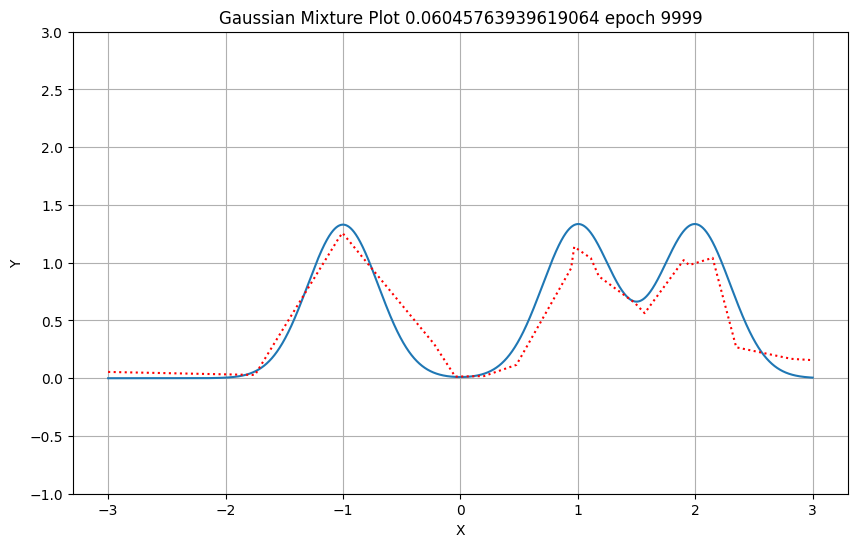

In [71]:
# theta = [0.1, 1, 2]

class DE_Family(nn.Module):
    def __init__(self, NP, CR, F):
        super(DE_Family, self).__init__()
        lin1s = nn.init.kaiming_uniform_(torch.empty((NP, 8, 4), requires_grad=False).to(device, non_blocking=True))
        lin2s = nn.init.kaiming_uniform_(torch.empty((NP, 12, 8), requires_grad=False).to(device, non_blocking=True))
        lin3s = nn.init.kaiming_uniform_(torch.empty((NP, 8, 12), requires_grad=False).to(device, non_blocking=True))
        lin4s = nn.init.kaiming_uniform_(torch.empty((NP, 4, 8), requires_grad=False).to(device, non_blocking=True))
        lin5s = nn.init.kaiming_uniform_(torch.empty((NP, 1, 4), requires_grad=False).to(device, non_blocking=True))
        self.layers = [lin1s, lin2s, lin3s, lin4s, lin5s]
        bias1 = nn.init.kaiming_uniform_(torch.empty((NP, 8, 1), requires_grad=False).to(device, non_blocking=True))
        bias2 = nn.init.kaiming_uniform_(torch.empty((NP, 12, 1), requires_grad=False).to(device, non_blocking=True))
        bias3 = nn.init.kaiming_uniform_(torch.empty((NP, 8, 1), requires_grad=False).to(device, non_blocking=True))
        bias4 = nn.init.kaiming_uniform_(torch.empty((NP, 4, 1), requires_grad=False).to(device, non_blocking=True))
        bias5 = nn.init.kaiming_uniform_(torch.empty((NP, 1, 1), requires_grad=False).to(device, non_blocking=True))
        self.biases = [bias1, bias2, bias3, bias4, bias5]
        
        max_size = 0
        for layer in self.layers:
            max_size = max(max_size, layer.numel())
        for bias in self.biases:
            max_size = max(max_size, bias.numel())
        diff_evo.pcg_init(max_size)
        self.max_size = max_size
        
        self.NP = NP
        self.CR = CR
        self.F = F
        self.min_f = torch.tensor(float('inf')).to(device)
        self.best_model = torch.tensor(0).to(device)
        self.fx = None
    def forward(self, X):
        for i in range(len(self.layers) - 1):
            X = torch.relu(torch.matmul(self.layers[i][self.best_model], X) + self.biases[i][self.best_model])
        return torch.matmul(self.layers[len(self.layers) - 1][self.best_model], X) + self.biases[len(self.layers) - 1][self.best_model]
    def forward_all(self, X, layers, biases):
        # This is just bmm???
        for i in range(len(layers) - 1):
            X = torch.relu(torch.einsum('lik,lkj->lij', layers[i], X) + biases[i])
        X = torch.einsum('lik,lkj->lij', layers[len(layers) - 1], X) + biases[len(layers) - 1]
        return X
    def step(self, X, Y, L, type='param'): # forward pass with candidate i
        if self.fx == None:
            self.fx = L(self.forward_all(X, self.layers, self.biases), Y).mean(dim = 2).squeeze(-1)
        
        #y_layers, y_biases = diff_evo.de_crossover_cuda(self.layers, self.biases, self.NP, self.CR, self.F, self.best_model)
        y_layers, y_biases = diff_evo.de_crossover_cuda2(self.layers, self.biases, self.NP, self.CR, self.F, self.best_model)
        #print(y_layers[0].shape, y_biases[0].shape)
        fy = L(self.forward_all(X, y_layers, y_biases), Y).mean(dim = 2).squeeze(-1)
        diff_evo.de_update_cuda(self.NP, self.layers, self.biases, y_layers, y_biases, self.fx, fy, self.min_f, self.best_model)

epochs = 10000
batch_size = 10000

def gaussian_mixture2(x, theta):
    return gaussian(x, theta[0]) + gaussian(x, theta[1]) + gaussian(x, theta[2])

def gaussian_family_mixture(X):
    return gaussian_mixture2(X[3], X[0:3])

NP = 44
CR = 0.9
F = 0.8
X = torch.rand(4, batch_size).to(device)
X[3] = X[3] * 5 - 2.5
X[0:3] = X[0:3] * 4 - 2

print(X.shape)
Y = gaussian_family_mixture(X).to(device)

print(X.shape, Y.shape)
X = X.unsqueeze(0).expand(NP, 4, batch_size)
Y = Y.unsqueeze(0).expand(NP, 1, batch_size)
print(X.shape, Y.shape)

model = DE_Family(NP, CR, F).to(device) 
model = torch.compile(model, mode="max-autotune")
print('pcg with max size', model.max_size)
L = nn.MSELoss(reduction='none')

Y_pred = model.forward_all(X, model.layers, model.biases)
print('output shape', Y_pred.shape)

my_theta = torch.tensor([-1.0, 1.0, 2.0]).to(device) # Move theta to device once
test_X_device = torch.empty(4, batch_size, device=device)
# Populate the fixed theta part of the tensor once
test_X_device[0:3, :] = my_theta.unsqueeze(1).expand(-1, batch_size)

for e in range(epochs):
    model.step(X, Y, L, 'block')
    if e % 100 == 0 or e == epochs - 1:
        with torch.no_grad():
            test_X_device[3, :] = torch.linspace(-3, 3, batch_size, device=device)
            test_Y = gaussian_family_mixture(test_X_device) 
            model_Y = model(test_X_device).cpu() 
            # Clear the previous output before plotting
            clear_output(wait=True)
            plt.figure(figsize=(10, 6))
            plt.plot(test_X_device[3].cpu().numpy(), test_Y.cpu().numpy(), label='Gaussian Mixture')
            plt.plot(test_X_device[3].cpu().numpy(), model_Y[0].numpy(), label='Predictions', color='red', linestyle='dotted')
            
            plt.title(f'Gaussian Mixture Plot {model.min_f.item()} epoch {e}')
            plt.xlabel('X')
            plt.ylabel('Y')
            plt.ylim(-1, 3)
            plt.grid(True)
            plt.show()


In [ ]:
diff_evo.pcg_destroy()